# Mount GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip3 install keras-self-attention

# Import libraries

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras import initializers, regularizers, constraints, optimizers, layers
from keras_self_attention import SeqSelfAttention
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


# Import data from GDrive

In [0]:
path =  "gdrive/My Drive/Colab Notebooks/Toxic Comments/"

In [0]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
test_labels = pd.read_csv(path + 'test_labels.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

# Preprocessing

Check for null values.

In [6]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [0]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

# Tokenize text

We tokenize words and sentences.

We need to identify ideal max length `maxlen` for sentence as well as max num of features `max_features`.

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [0]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

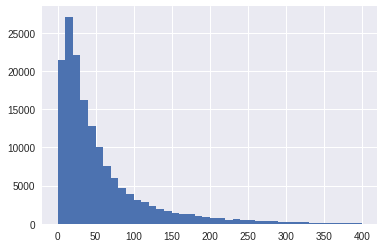

In [10]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [0]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

# Define helper methods

Define ROC AOC and a method for plotting train and validation loss.

In [0]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [0]:
def plot_history(hs, epochs):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history['loss'], label='{0:s} train loss'.format(label))
        plt.plot(hs[label].history['val_loss'], label='{0:s} validation loss'.format(label))
    x_ticks = np.arange(0, epochs + 1, epochs / 5)
    x_ticks [0] += 1
    plt.xticks(x_ticks-1, ('1', '1', '2', '3', '4', '5'))
    plt.ylim((0, 0.1))
    plt.xlabel('Epochs')
    plt.ylabel('binary crossentropy')
    plt.legend()
    plt.show()

# Compiling the model

In [0]:
def compile_model(dropout=0.2, lr=0.1):
  inp = Input(shape=(maxlen, ))
  embed_size = 128
  x = Embedding(max_features, embed_size)(inp)
  x = CuDNNLSTM(128, return_sequences=True)(x)
  x = Dropout(dropout)(x)
  x = SeqSelfAttention()(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(6, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
  return model

# Split train data

We split train data into train, held-out and validation data.

In [15]:
X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.9)
X_tra, X_hel, y_tra, y_hel = train_test_split(X_tra, y_tra, train_size=0.9)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Hyper-parameter tuning for learning rate

In [16]:
epochs = 1
batch_size = 32
RocAuc = RocAucEvaluation(validation_data=(X_hel, y_hel), interval=1)

for i in range(1, 5):
  lr = i/1000
  model = compile_model(lr=lr)
  print("Learning rate: {:.3f}".format(lr))
  history = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_hel, y_hel),
                 callbacks=[RocAuc], verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Learning rate: 0.001
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 312s - loss: 0.0745 - acc: 0.9757 - val_loss: 0.0481 - val_acc: 0.9825

 ROC-AUC - epoch: 1 - score: 0.977226
Learning rate: 0.002
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 313s - loss: 0.0622 - acc: 0.9791 - val_loss: 0.0447 - val_acc: 0.9834

 ROC-AUC - epoch: 1 - score: 0.981692
Learning rate: 0.003
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 315s - loss: 0.0643 - acc: 0.9783 - val_loss: 0.0457 - val_acc: 0.9827

 ROC-AUC - epoch: 1 - score: 0.980762
Learning rate: 0.004
Train on 129251 samples, validate on 14362 samples
Epoch 1/1
 - 315s - loss: 0.06

# Early stopping

In [17]:
epochs = 5

model = compile_model(lr=0.002)

RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

history = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=2)

Train on 129251 samples, validate on 15958 samples
Epoch 1/5
 - 316s - loss: 0.0652 - acc: 0.9782 - val_loss: 0.0485 - val_acc: 0.9821

 ROC-AUC - epoch: 1 - score: 0.979816
Epoch 2/5
 - 315s - loss: 0.0440 - acc: 0.9834 - val_loss: 0.0471 - val_acc: 0.9827

 ROC-AUC - epoch: 2 - score: 0.983439
Epoch 3/5
 - 315s - loss: 0.0385 - acc: 0.9850 - val_loss: 0.0458 - val_acc: 0.9827

 ROC-AUC - epoch: 3 - score: 0.983998
Epoch 4/5
 - 315s - loss: 0.0341 - acc: 0.9866 - val_loss: 0.0492 - val_acc: 0.9819

 ROC-AUC - epoch: 4 - score: 0.982776
Epoch 5/5
 - 317s - loss: 0.0301 - acc: 0.9881 - val_loss: 0.0519 - val_acc: 0.9819

 ROC-AUC - epoch: 5 - score: 0.981163


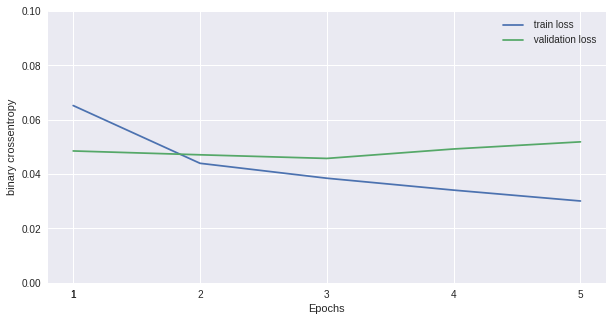

In [18]:
plot = plot_history(hs={'': history}, epochs=epochs)

# Train final model

Use full training set with the final parameters

In [19]:
model = compile_model(lr=0.002)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 200, 128)          132096    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
seq_self_attention_6 (SeqSel (None, 200, 128)          8257      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
Total para

In [20]:
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs)

Epoch 1/2
159571/159571 [==============================] - 398s 2ms/step - loss: 0.0605 - acc: 0.9795
Epoch 2/2
159571/159571 [==============================] - 395s 2ms/step - loss: 0.0426 - acc: 0.9838


# Predict test

In [21]:
predictions = model.predict(X_te, batch_size=batch_size, verbose=1)

153164/153164 [==============================] - 125s 814us/step


# Save predictions for submission

In [0]:
sample_submission[list_classes] = predictions

In [0]:
sample_submission.to_csv(path + 'submission.csv', index=False)